In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import glob

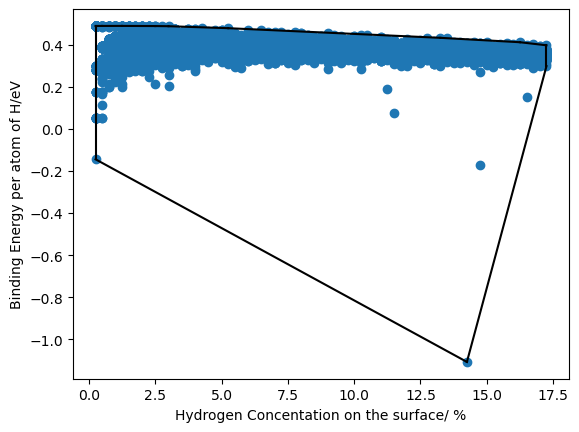

In [2]:
data_lst = []
for file in glob.glob('../../H_Surface_Data_2/data_*.txt'):
    data_temp = np.loadtxt(file)
    data_lst.append(data_temp)

data = np.vstack(data_lst)
points = data[:,[1,2]]
hull = ConvexHull(points)

plt.scatter(data[:,1], data[:, 2])
plt.xlabel('Hydrogen Concentation on the surface/ %')
plt.ylabel('Binding Energy per atom of H/eV')

for simplex in hull.simplices:
    plt.plot([points[i][0] for i in simplex], [points[i][1] for i in simplex], 'k-')


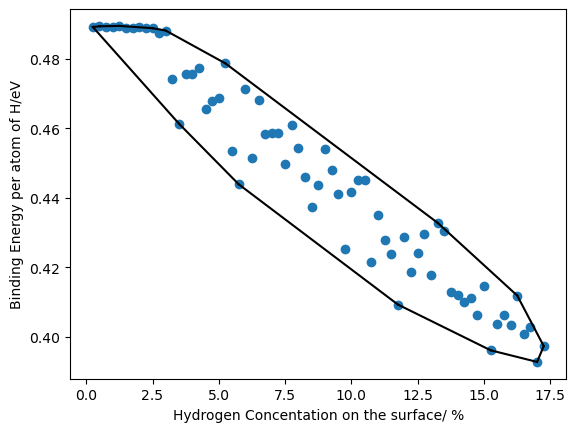

In [3]:
unique_elements, counts = np.unique(data[:,1], return_counts=True)

max_energy = np.zeros(len(unique_elements,))

for i, element in enumerate(unique_elements):
    idx = np.where(data[:, 1] == element)[0]
    max_energy[i] = data[idx, 2].max()

points = np.hstack([unique_elements.reshape(-1,1), max_energy.reshape(-1,1)])
hull = ConvexHull(points)

plt.scatter(unique_elements.reshape(-1,1), max_energy.reshape(-1,1))
plt.xlabel('Hydrogen Concentation on the surface/ %')
plt.ylabel('Binding Energy per atom of H/eV')

for simplex in hull.simplices:
    plt.plot([points[i][0] for i in simplex], [points[i][1] for i in simplex], 'k-')

In [4]:
def find_max_path(hull):
    vertices = points[hull.vertices]
    start_idx = vertices[:,0].argmin()
    end_idx = vertices[:,0].argmax()

    start = hull.vertices[start_idx]
    end = hull.vertices[end_idx]

    current = [start]
    
    visited = []

    while end not in visited:
        connections = []
        for simplex in hull.simplices:
            if current in simplex:
                idx = simplex[simplex != current]
                if idx not in visited:
                    connections.append(idx)

        visited.append(current)
        cost = points[connections][:,:,1]
        current = connections[cost.argmax()].tolist()

    visited = np.array(visited).flatten()

    return visited



In [5]:
def MAP(x_train, y_train, prior_mean, prior_var, deg = 5):

    if x_train.ndim == 1:
        x_train= x_train.reshape(-1, 1)

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    if prior_mean.ndim == 1:
        prior_mean= prior_mean.reshape(-1, 1)

    Phi = np.hstack([x_train**i for i in range(deg)])
    
    theta = np.linalg.solve( np.eye(len(prior_mean))/prior_var + Phi.T@Phi, prior_mean/prior_var + Phi.T@y_train)

    return theta

def MLE(x_train, y_train, deg):
    
    if x_train.ndim == 1:
        x_train= x_train.reshape(-1, 1)

    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)

    Phi = np.hstack([x_train**i for i in range(deg)])

    var = (x_train/100)**2

    Phi_sigma = Phi/var

    theta = np.linalg.solve(Phi_sigma.T @ Phi, Phi_sigma.T @ y_train)

    return theta

In [6]:
def fit_piecewise_linear(pts):

    coef = np.zeros((len(pts) -1, 2))
    for i in range(len(pts) - 1):
        coef[i] = np.polyfit(pts[i: i+2,0], pts[i:i+2, 1], deg =  1)
    return coef

def val_piecewise_linear(coef, x):
    val = np.array([np.polyval(_coef, x) for _coef in coef])
    return np.min(val, axis = 0)

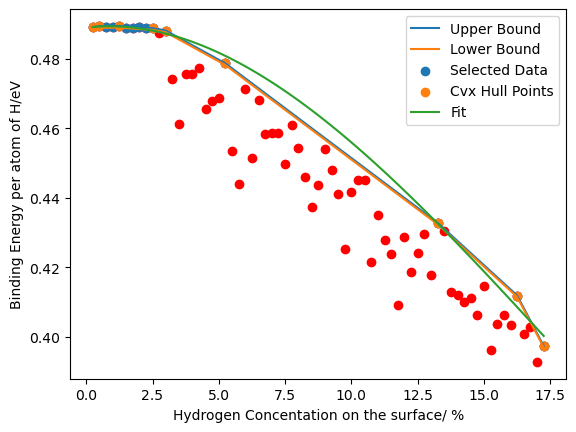

In [10]:

x_data = unique_elements
y_data = max_energy
data = np.hstack([x_data.reshape(-1, 1), y_data.reshape(-1, 1)])

thresh = 0.999

cvx_idx = find_max_path(hull)

cvx_pts = points[cvx_idx]

coef_upper = fit_piecewise_linear(cvx_pts)

coef_lower = coef_upper*thresh


x_fit = np.linspace(cvx_pts[:,0].min(), cvx_pts[:,0].max(), 100)

y_fit = val_piecewise_linear(coef_upper, x_fit)

plt.plot(x_fit, y_fit, label= 'Upper Bound')

plt.plot(x_fit, thresh*y_fit, label='Lower Bound')

plt.scatter(x_data, y_data,color='r')

data_slct = np.array([ [x, y] for x, y in data if val_piecewise_linear(coef_lower, x) <= y])

plt.scatter(data_slct[:,0], data_slct[:, 1], label='Selected Data')

plt.scatter(cvx_pts[:,0], cvx_pts[:,1],label='Cvx Hull Points')

theta = MLE(data_slct[:,0], data_slct[:,1], deg = 4)

theta = theta[::-1]

y_fit = np.polyval(theta, x_fit)

plt.plot(x_fit, y_fit, label='Fit')

plt.xlabel('Hydrogen Concentation on the surface/ %')
plt.ylabel('Binding Energy per atom of H/eV')
plt.legend()

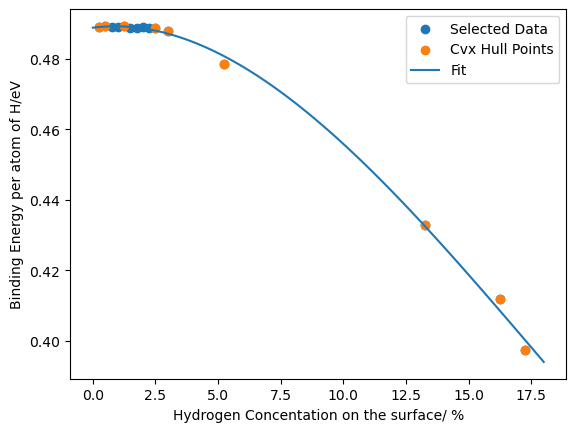

In [11]:

plt.scatter(data_slct[:,0], data_slct[:, 1], label='Selected Data')

plt.scatter(cvx_pts[:,0], cvx_pts[:,1],label='Cvx Hull Points')

theta = MLE(data_slct[:,0], data_slct[:,1], deg = 4)

dy_theta = np.array([power*coef for power, coef in enumerate(theta)])
dy_theta = dy_theta[1:]

theta = theta[::-1]
dy_theta = dy_theta[::-1]

x_fit = np.linspace(0, 18, 100)
y_fit = np.polyval(theta, x_fit)

dy_fit = np.polyval(dy_theta, x_fit)

plt.plot(x_fit, y_fit, label='Fit')
plt.xlabel('Hydrogen Concentation on the surface/ %')
plt.ylabel('Binding Energy per atom of H/eV')
plt.legend()

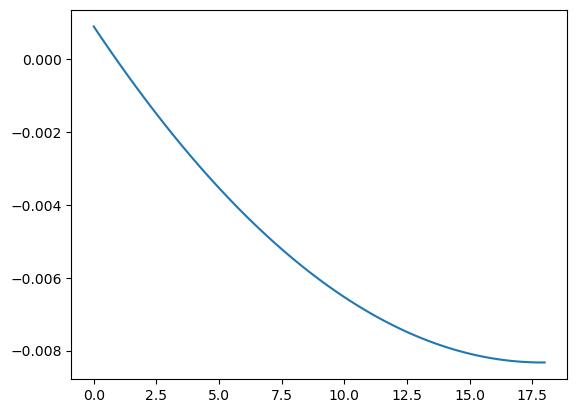

In [9]:
plt.plot(x_fit, dy_fit, label='Fit')
plt.xlabel('Hydrogen Concentation on the surface/ %')
plt.ylabel('Addition Energy /eV')